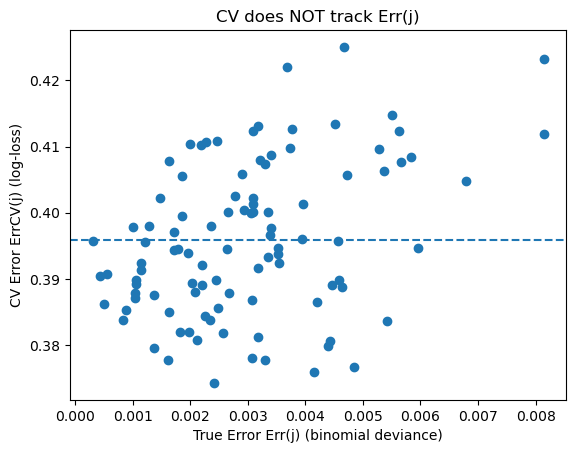

Mean Err    = 0.002997592372611834
SD   Err    = 0.0015976567072792072
Mean ErrCV  = 0.3958381095887307
SD   ErrCV  = 0.011500950581779005


In [3]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

np.random.seed(0)

# 固定 x，不同模拟生成不同 y
n = 2000
p = 5
x = np.random.normal(0, 1, (n, p))
beta = np.array([1, -2, 0.5, 1, -1])

def true_mu(x):
    return 1 / (1 + np.exp(-x.dot(beta)))

def true_bernoulli_deviance(mu, yhat):
    """
    真实误差：用 Bernoulli(mu) 和 Bernoulli(yhat) 的 binomial deviance
    相当于 2 * KL(mu || yhat) 的样本均值
    """
    eps = 1e-15
    mu_c = np.clip(mu, eps, 1 - eps)
    yhat_c = np.clip(yhat, eps, 1 - eps)
    dev = 2 * (mu_c * np.log(mu_c / yhat_c) +
               (1 - mu_c) * np.log((1 - mu_c) / (1 - yhat_c)))
    return dev.mean()

Err_list = []
ErrCV_list = []

num_sim = 100

for j in range(num_sim):
    # --- 1. 生成新的 y ---
    mu = true_mu(x)
    y = np.random.binomial(1, mu)

    # --- 2. 拟合模型 ---
    clf = LogisticRegression(solver='lbfgs', max_iter=1000)
    clf.fit(x, y)

    # --- 3. 真实误差 Err(j)：用真实 mu 计算 binomial deviance ---
    yhat = clf.predict_proba(x)[:, 1]
    Err = true_bernoulli_deviance(mu, yhat)
    Err_list.append(Err)

    # --- 4. CV 误差 ErrCV(j)：50-fold CV 的负 log-loss 平均 ---
    # 这里 y_true 是 0/1，符合 sklearn 要求
    ErrCV = -np.mean(
        cross_val_score(
            LogisticRegression(solver='lbfgs', max_iter=1000),
            x, y, cv=50, scoring='neg_log_loss'
        )
    )
    ErrCV_list.append(ErrCV)

# ====== 画散点图 ======
plt.scatter(Err_list, ErrCV_list)
plt.xlabel("True Error Err(j) (binomial deviance)")
plt.ylabel("CV Error ErrCV(j) (log-loss)")
plt.title("CV does NOT track Err(j)")
plt.axhline(np.mean(ErrCV_list), linestyle='--')
plt.show()

print("Mean Err    =", np.mean(Err_list))
print("SD   Err    =", np.std(Err_list))
print("Mean ErrCV  =", np.mean(ErrCV_list))
print("SD   ErrCV  =", np.std(ErrCV_list))
